# Phase 4: Deeper Effect Analysis

**Swiss Ballot Chatbot Study - Measurement Analysis**

2x2 Factorial Design: Transparency (T0/T1) x Control (C0/C1)

## Purpose

| Analysis | Purpose |
|----------|--------|
| Marginal effects at means | Probability changes per IV |
| Predicted probabilities per condition | Visualize interaction |
| Simple effects (if interaction significant) | T effect within C0/C1; C effect within T0/T1 |
| Predicted probabilities for A/B/C/D from Model 4 | Standardized condition-level interpretation |

## Outputs

- Predicted probabilities of donation for each condition A/B/C/D (from Model 4; optionally Model 5 as robustness) with 95% CI
- Marginal effects (Δ probability) for T and C (and for the interaction if significant)
- If T×C significant: simple effects table
- Visualization: interaction plot / bar chart of predicted probabilities for A/B/C/D with CI

## Setup & Imports

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels for logistic regression
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

# Import from Phase 1
from phase1_descriptive_statistics import (
    AnalysisConfig,
    load_participant_data,
    prepare_variables,
    compute_sample_flow,
    wilson_ci
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Significance threshold
ALPHA = 0.05

print("Setup complete!")

Setup complete!


## Configuration

In [2]:
# Set participant type: 'ai' for AI test users, 'human' for real participants
PARTICIPANT_TYPE = 'human'

config = AnalysisConfig(is_ai_participant=(PARTICIPANT_TYPE == 'ai'))
print(f"Analyzing: {'AI Test Users' if PARTICIPANT_TYPE == 'ai' else 'Human Participants'}")

Analyzing: Human Participants


## Load and Prepare Data

In [3]:
# Load data
df_raw = load_participant_data(config)
df = prepare_variables(df_raw, config)

# Apply exclusions
sample_flow = compute_sample_flow(df)
df_filtered = sample_flow['df_filtered']

print(f"\nFinal sample size: N = {len(df_filtered)}")

[INFO] Loaded 291 human participants from database
[INFO] Language codes cleaned: ['de-DE', 'de', 'en-GB', 'en-US', 'en', 'en-CH', 'de-CH', 'fr', 'fr-CH', 'fr-FR', 'en-AU', 'es-ES', 'it', 'gsw'] → ['de', 'en', 'fr', 'other', 'it']
[INFO] Applied language code cleaning for human participants
[INFO] Created derived variables: transparency_level, control_level, T_x_C, mc_transparency, mc_control, out_risk, attention_check_correct, attention_check_missing, attention_check_failed, dashboard fields

PHASE 1.1: SAMPLE FLOW & EXCLUSIONS
Initial N:                           291
Excluded (incomplete survey):         79
Excluded (failed attention):           7
Excluded (missing condition):          0
Excluded (missing donation):           0
------------------------------------------------------------
Final N for analysis:                205

Final sample size: N = 205


## Fit Primary Model (Model 4)

In [4]:
# Fit Model 4: Donation ~ T + C + T×C
y = df_filtered['donation_decision'].values
X4 = sm.add_constant(df_filtered[['transparency_level', 'control_level', 'T_x_C']])

model4 = Logit(y, X4).fit(disp=0)

print("Model 4 fitted: Donation ~ T + C + T×C")
print(f"Converged: {model4.mle_retvals['converged']}")
print(f"\nCoefficients:")
print(model4.params.round(4))

Model 4 fitted: Donation ~ T + C + T×C
Converged: True

Coefficients:
const                 2.1972
transparency_level    0.0645
control_level         0.4418
T_x_C                -0.1196
dtype: float64


## Predicted Probabilities by Condition

In [5]:
def predict_probability(model, T, C):
    """Calculate predicted probability and SE using delta method."""
    TxC = T * C
    X = np.array([1, T, C, TxC])
    
    # Predicted probability
    linear_pred = np.dot(X, model.params)
    prob = 1 / (1 + np.exp(-linear_pred))
    
    # Standard error using delta method
    # Var(p) = p(1-p)^2 * X' * Cov(beta) * X
    cov_matrix = model.cov_params()
    var_linear = np.dot(np.dot(X, cov_matrix), X)
    se_prob = prob * (1 - prob) * np.sqrt(var_linear)
    
    # 95% CI
    ci_lower = max(0, prob - 1.96 * se_prob)
    ci_upper = min(1, prob + 1.96 * se_prob)
    
    return prob, se_prob, ci_lower, ci_upper


# Calculate predicted probabilities for each condition
conditions = {
    'A': (0, 0),  # T0C0
    'B': (1, 0),  # T1C0
    'C': (0, 1),  # T0C1
    'D': (1, 1)   # T1C1
}

pred_results = []
for cond, (T, C) in conditions.items():
    prob, se, ci_lo, ci_hi = predict_probability(model4, T, C)
    
    # Also get observed values
    cond_df = df_filtered[df_filtered['condition'] == cond]
    n = len(cond_df)
    observed = cond_df['donation_decision'].mean()
    obs_ci = wilson_ci(int(cond_df['donation_decision'].sum()), n)
    
    pred_results.append({
        'Condition': cond,
        'T': T,
        'C': C,
        'n': n,
        'Observed (%)': round(observed * 100, 1),
        'Obs 95% CI': f"[{obs_ci[0]*100:.1f}, {obs_ci[1]*100:.1f}]",
        'Predicted (%)': round(prob * 100, 1),
        'Pred SE': round(se * 100, 1),
        'Pred 95% CI': f"[{ci_lo*100:.1f}, {ci_hi*100:.1f}]"
    })

pred_df = pd.DataFrame(pred_results)
print("PREDICTED PROBABILITIES BY CONDITION (Model 4)")
print("=" * 80)
pred_df

PREDICTED PROBABILITIES BY CONDITION (Model 4)


,Condition,T,C,n,Observed (%),Obs 95% CI,Predicted (%),Pred SE,Pred 95% CI
0,A,0,0,50,90.0,"[78.6, 95.7]",90.0,4.2,"[81.7, 98.3]"
1,B,1,0,53,90.6,"[79.7, 95.9]",90.6,4.0,"[82.7, 98.4]"
2,C,0,1,45,93.3,"[82.1, 97.7]",93.3,3.7,"[86.0, 100.0]"
3,D,1,1,57,93.0,"[83.3, 97.2]",93.0,3.4,"[86.4, 99.6]"


## Marginal Effects

In [6]:
def calculate_marginal_effect(model, df, variable):
    """
    Calculate average marginal effect for a binary variable.
    AME = average change in predicted probability when variable changes from 0 to 1.
    """
    # Get coefficients
    beta = model.params
    
    # For each observation, calculate the change in probability
    marginal_effects = []
    
    for idx, row in df.iterrows():
        T = row['transparency_level']
        C = row['control_level']
        
        if variable == 'transparency_level':
            # Probability when T=1 vs T=0 (holding C constant)
            X0 = np.array([1, 0, C, 0 * C])
            X1 = np.array([1, 1, C, 1 * C])
        else:  # control_level
            # Probability when C=1 vs C=0 (holding T constant)
            X0 = np.array([1, T, 0, T * 0])
            X1 = np.array([1, T, 1, T * 1])
        
        p0 = 1 / (1 + np.exp(-np.dot(X0, beta)))
        p1 = 1 / (1 + np.exp(-np.dot(X1, beta)))
        
        marginal_effects.append(p1 - p0)
    
    ame = np.mean(marginal_effects)
    se_ame = np.std(marginal_effects) / np.sqrt(len(marginal_effects))
    
    return ame, se_ame


# Calculate marginal effects
ame_t, se_t = calculate_marginal_effect(model4, df_filtered, 'transparency_level')
ame_c, se_c = calculate_marginal_effect(model4, df_filtered, 'control_level')

print("AVERAGE MARGINAL EFFECTS (AME)")
print("=" * 60)
print(f"\nTransparency Effect (T1 vs T0):")
print(f"  AME = {ame_t*100:.1f} percentage points")
print(f"  SE  = {se_t*100:.1f} pp")
print(f"  95% CI: [{(ame_t - 1.96*se_t)*100:.1f}, {(ame_t + 1.96*se_t)*100:.1f}] pp")
print(f"  Interpretation: Showing the Data Nutrition Label {'increases' if ame_t > 0 else 'decreases'}")
print(f"                  donation probability by {abs(ame_t)*100:.1f} percentage points on average.")

print(f"\nControl Effect (C1 vs C0):")
print(f"  AME = {ame_c*100:.1f} percentage points")
print(f"  SE  = {se_c*100:.1f} pp")
print(f"  95% CI: [{(ame_c - 1.96*se_c)*100:.1f}, {(ame_c + 1.96*se_c)*100:.1f}] pp")
print(f"  Interpretation: Showing the Granular Dashboard {'increases' if ame_c > 0 else 'decreases'}")
print(f"                  donation probability by {abs(ame_c)*100:.1f} percentage points on average.")

AVERAGE MARGINAL EFFECTS (AME)

Transparency Effect (T1 vs T0):
  AME = 0.1 percentage points
  SE  = 0.0 pp
  95% CI: [0.0, 0.2] pp
  Interpretation: Showing the Data Nutrition Label increases
                  donation probability by 0.1 percentage points on average.

Control Effect (C1 vs C0):
  AME = 2.8 percentage points
  SE  = 0.0 pp
  95% CI: [2.8, 2.9] pp
  Interpretation: Showing the Granular Dashboard increases
                  donation probability by 2.8 percentage points on average.


## Simple Effects Analysis (If Interaction Significant)

In [7]:
# Check if interaction is significant
p_interaction = model4.pvalues['T_x_C']
interaction_significant = p_interaction < ALPHA

print("SIMPLE EFFECTS ANALYSIS")
print("=" * 60)
print(f"\nInteraction p-value: {p_interaction:.4f}")
print(f"Interaction significant (α = {ALPHA}): {'Yes' if interaction_significant else 'No'}")

# Calculate simple effects regardless (for completeness)
print("\n--- Simple Effects of Transparency (T) ---")

# Effect of T within C0
p_a = pred_df[pred_df['Condition'] == 'A']['Predicted (%)'].values[0] / 100
p_b = pred_df[pred_df['Condition'] == 'B']['Predicted (%)'].values[0] / 100
effect_t_at_c0 = p_b - p_a
print(f"\nEffect of T at C0 (Low Control):")
print(f"  P(Donate|T1,C0) - P(Donate|T0,C0) = {p_b*100:.1f}% - {p_a*100:.1f}% = {effect_t_at_c0*100:.1f} pp")

# Effect of T within C1
p_c = pred_df[pred_df['Condition'] == 'C']['Predicted (%)'].values[0] / 100
p_d = pred_df[pred_df['Condition'] == 'D']['Predicted (%)'].values[0] / 100
effect_t_at_c1 = p_d - p_c
print(f"\nEffect of T at C1 (High Control):")
print(f"  P(Donate|T1,C1) - P(Donate|T0,C1) = {p_d*100:.1f}% - {p_c*100:.1f}% = {effect_t_at_c1*100:.1f} pp")

print("\n--- Simple Effects of Control (C) ---")

# Effect of C within T0
effect_c_at_t0 = p_c - p_a
print(f"\nEffect of C at T0 (Low Transparency):")
print(f"  P(Donate|T0,C1) - P(Donate|T0,C0) = {p_c*100:.1f}% - {p_a*100:.1f}% = {effect_c_at_t0*100:.1f} pp")

# Effect of C within T1
effect_c_at_t1 = p_d - p_b
print(f"\nEffect of C at T1 (High Transparency):")
print(f"  P(Donate|T1,C1) - P(Donate|T1,C0) = {p_d*100:.1f}% - {p_b*100:.1f}% = {effect_c_at_t1*100:.1f} pp")

# Summary table
simple_effects = pd.DataFrame([
    {'Effect': 'T effect at C0', 'Δ Probability': f"{effect_t_at_c0*100:.1f} pp", 
     'From': f"A ({p_a*100:.1f}%)", 'To': f"B ({p_b*100:.1f}%)"},
    {'Effect': 'T effect at C1', 'Δ Probability': f"{effect_t_at_c1*100:.1f} pp",
     'From': f"C ({p_c*100:.1f}%)", 'To': f"D ({p_d*100:.1f}%)"},
    {'Effect': 'C effect at T0', 'Δ Probability': f"{effect_c_at_t0*100:.1f} pp",
     'From': f"A ({p_a*100:.1f}%)", 'To': f"C ({p_c*100:.1f}%)"},
    {'Effect': 'C effect at T1', 'Δ Probability': f"{effect_c_at_t1*100:.1f} pp",
     'From': f"B ({p_b*100:.1f}%)", 'To': f"D ({p_d*100:.1f}%)"},
])

print("\n" + "=" * 60)
print("Simple Effects Summary:")
simple_effects

SIMPLE EFFECTS ANALYSIS

Interaction p-value: 0.9079
Interaction significant (α = 0.05): No

--- Simple Effects of Transparency (T) ---

Effect of T at C0 (Low Control):
  P(Donate|T1,C0) - P(Donate|T0,C0) = 90.6% - 90.0% = 0.6 pp

Effect of T at C1 (High Control):
  P(Donate|T1,C1) - P(Donate|T0,C1) = 93.0% - 93.3% = -0.3 pp

--- Simple Effects of Control (C) ---

Effect of C at T0 (Low Transparency):
  P(Donate|T0,C1) - P(Donate|T0,C0) = 93.3% - 90.0% = 3.3 pp

Effect of C at T1 (High Transparency):
  P(Donate|T1,C1) - P(Donate|T1,C0) = 93.0% - 90.6% = 2.4 pp

Simple Effects Summary:


,Effect,Δ Probability,From,To
0,T effect at C0,0.6 pp,A (90.0%),B (90.6%)
1,T effect at C1,-0.3 pp,C (93.3%),D (93.0%)
2,C effect at T0,3.3 pp,A (90.0%),C (93.3%)
3,C effect at T1,2.4 pp,B (90.6%),D (93.0%)


## Interaction Interpretation

In [8]:
print("INTERACTION INTERPRETATION")
print("=" * 60)

# Calculate interaction magnitude
interaction_effect = (effect_t_at_c1 - effect_t_at_c0)
# Equivalently: (effect_c_at_t1 - effect_c_at_t0)

print(f"\nInteraction magnitude:")
print(f"  (T effect at C1) - (T effect at C0) = {effect_t_at_c1*100:.1f} - {effect_t_at_c0*100:.1f} = {interaction_effect*100:.1f} pp")

# Interpret pattern
if interaction_effect > 5:  # arbitrary threshold for meaningful difference
    pattern = "synergistic"
    explanation = "The effect of transparency is STRONGER when control is high."
elif interaction_effect < -5:
    pattern = "antagonistic"
    explanation = "The effect of transparency is WEAKER when control is high."
else:
    pattern = "additive"
    explanation = "The effects of transparency and control are roughly additive (no meaningful interaction)."

print(f"\nPattern: {pattern.upper()}")
print(f"  {explanation}")

# H3 interpretation
print(f"\nH3 (Synergistic interaction):")
if interaction_significant and interaction_effect > 0:
    print("  ✓ SUPPORTED: Significant positive interaction found.")
    print(f"    Combined T+C effect ({(p_d - p_a)*100:.1f} pp) exceeds sum of individual effects.")
elif interaction_significant and interaction_effect < 0:
    print("  ✗ NOT SUPPORTED: Significant but antagonistic interaction.")
    print(f"    Combined effect is less than sum of individual effects.")
else:
    print("  ✗ NOT SUPPORTED: No significant interaction.")
    print(f"    Effects appear additive (interaction p = {p_interaction:.4f}).")

INTERACTION INTERPRETATION

Interaction magnitude:
  (T effect at C1) - (T effect at C0) = -0.3 - 0.6 = -0.9 pp

Pattern: ADDITIVE
  The effects of transparency and control are roughly additive (no meaningful interaction).

H3 (Synergistic interaction):
  ✗ NOT SUPPORTED: No significant interaction.
    Effects appear additive (interaction p = 0.9079).


## Visualizations

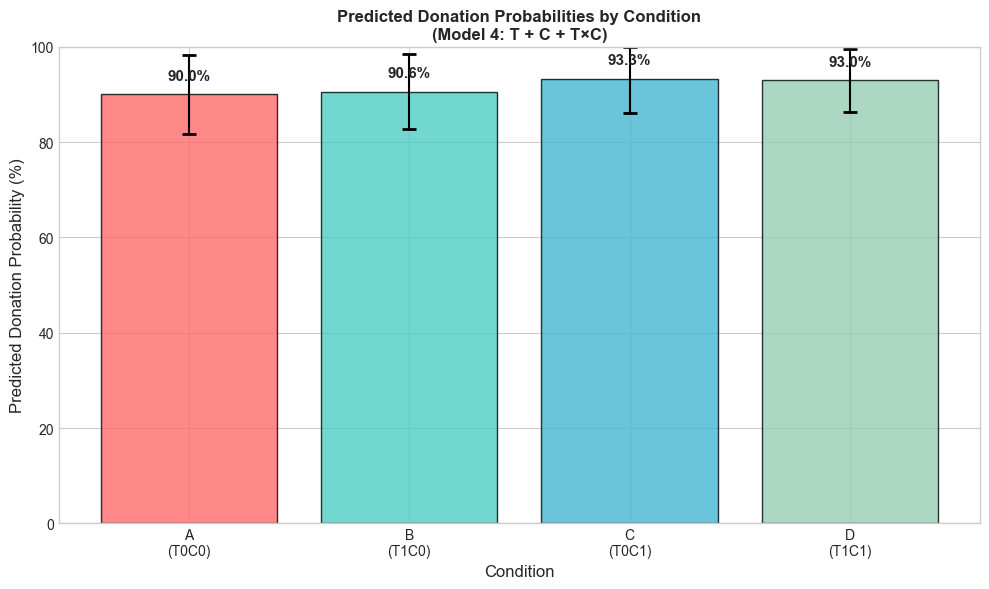

In [9]:
# Figure 1: Predicted Probabilities Bar Chart with CI
fig, ax = plt.subplots(figsize=(10, 6))

conditions = ['A\n(T0C0)', 'B\n(T1C0)', 'C\n(T0C1)', 'D\n(T1C1)']
probs = [p_a, p_b, p_c, p_d]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# Get CIs from pred_df
ci_lower = []
ci_upper = []
for cond in ['A', 'B', 'C', 'D']:
    prob, se, lo, hi = predict_probability(model4, 
                                           1 if cond in ['B', 'D'] else 0,
                                           1 if cond in ['C', 'D'] else 0)
    ci_lower.append(lo)
    ci_upper.append(hi)

# Plot bars
bars = ax.bar(conditions, [p*100 for p in probs], color=colors, edgecolor='black', alpha=0.8)

# Add error bars
errors_low = [(p - lo)*100 for p, lo in zip(probs, ci_lower)]
errors_high = [(hi - p)*100 for p, hi in zip(probs, ci_upper)]
ax.errorbar(conditions, [p*100 for p in probs], 
            yerr=[errors_low, errors_high],
            fmt='none', color='black', capsize=5, capthick=2)

# Add value labels
for bar, prob in zip(bars, probs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3,
            f'{prob*100:.1f}%', ha='center', fontsize=11, fontweight='bold')

ax.set_ylabel('Predicted Donation Probability (%)', fontsize=12)
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylim(0, 100)
ax.set_title('Predicted Donation Probabilities by Condition\n(Model 4: T + C + T×C)',
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

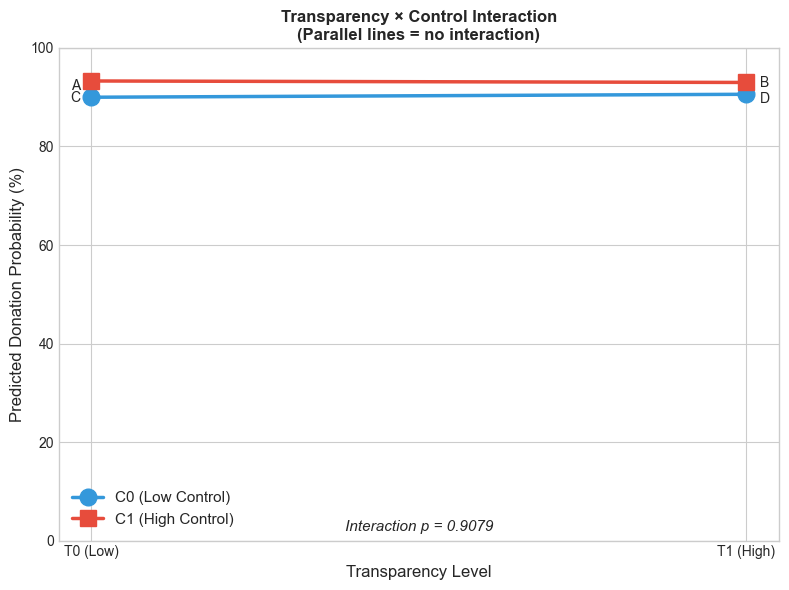

In [10]:
# Figure 2: Interaction Plot
fig, ax = plt.subplots(figsize=(8, 6))

# C0 line (Low Control)
ax.plot(['T0 (Low)', 'T1 (High)'], [p_a*100, p_b*100], 'o-', 
        label='C0 (Low Control)', color='#3498db', linewidth=2.5, markersize=12)

# C1 line (High Control)
ax.plot(['T0 (Low)', 'T1 (High)'], [p_c*100, p_d*100], 's-', 
        label='C1 (High Control)', color='#e74c3c', linewidth=2.5, markersize=12)

# Add condition labels
ax.annotate('A', (0, p_a*100), textcoords="offset points", xytext=(-15,5), fontsize=10)
ax.annotate('B', (1, p_b*100), textcoords="offset points", xytext=(10,5), fontsize=10)
ax.annotate('C', (0, p_c*100), textcoords="offset points", xytext=(-15,-15), fontsize=10)
ax.annotate('D', (1, p_d*100), textcoords="offset points", xytext=(10,-15), fontsize=10)

ax.set_ylabel('Predicted Donation Probability (%)', fontsize=12)
ax.set_xlabel('Transparency Level', fontsize=12)
ax.set_ylim(0, 100)
ax.legend(loc='best', fontsize=11)

# Interaction annotation
sig_text = f"Interaction p = {p_interaction:.4f}" + (" *" if interaction_significant else "")
ax.text(0.5, 0.02, sig_text, transform=ax.transAxes, ha='center', fontsize=11, style='italic')

ax.set_title('Transparency × Control Interaction\n(Parallel lines = no interaction)',
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

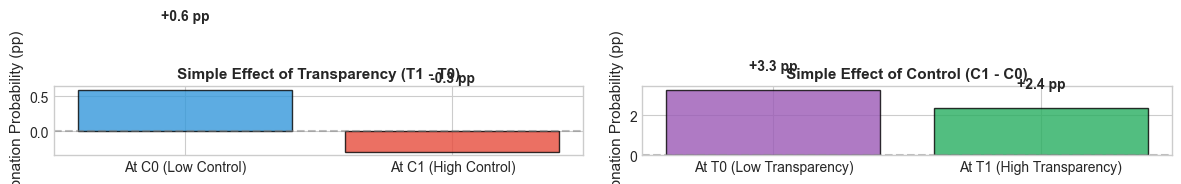

In [11]:
# Figure 3: Simple Effects Comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Transparency effect by Control level
ax1 = axes[0]
x = ['At C0 (Low Control)', 'At C1 (High Control)']
effects_t = [effect_t_at_c0*100, effect_t_at_c1*100]
colors_t = ['#3498db', '#e74c3c']
bars1 = ax1.bar(x, effects_t, color=colors_t, edgecolor='black', alpha=0.8)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.set_ylabel('Δ Donation Probability (pp)', fontsize=11)
ax1.set_title('Simple Effect of Transparency (T1 - T0)', fontsize=11, fontweight='bold')
for bar, eff in zip(bars1, effects_t):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{eff:+.1f} pp', ha='center', fontsize=10, fontweight='bold')

# Right: Control effect by Transparency level
ax2 = axes[1]
x = ['At T0 (Low Transparency)', 'At T1 (High Transparency)']
effects_c = [effect_c_at_t0*100, effect_c_at_t1*100]
colors_c = ['#9b59b6', '#27ae60']
bars2 = ax2.bar(x, effects_c, color=colors_c, edgecolor='black', alpha=0.8)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.set_ylabel('Δ Donation Probability (pp)', fontsize=11)
ax2.set_title('Simple Effect of Control (C1 - C0)', fontsize=11, fontweight='bold')
for bar, eff in zip(bars2, effects_c):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{eff:+.1f} pp', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Save Results

In [12]:
# Create output directory
output_dir = './output/phase4'
os.makedirs(output_dir, exist_ok=True)

# Save predicted probabilities
pred_df.to_csv(f'{output_dir}/phase4_predicted_probabilities_{PARTICIPANT_TYPE}.csv', index=False)

# Save simple effects
simple_effects.to_csv(f'{output_dir}/phase4_simple_effects_{PARTICIPANT_TYPE}.csv', index=False)

# Save marginal effects
marginal_df = pd.DataFrame([
    {'Variable': 'Transparency (T)', 'AME': f"{ame_t*100:.1f} pp", 'SE': f"{se_t*100:.1f} pp"},
    {'Variable': 'Control (C)', 'AME': f"{ame_c*100:.1f} pp", 'SE': f"{se_c*100:.1f} pp"}
])
marginal_df.to_csv(f'{output_dir}/phase4_marginal_effects_{PARTICIPANT_TYPE}.csv', index=False)

print(f"Results saved to {output_dir}/")

Results saved to ./output/phase4/


In [13]:
# Summary
print("\n" + "="*70)
print("PHASE 4 SUMMARY")
print("="*70)
print(f"""
PREDICTED DONATION PROBABILITIES (Model 4):
  Condition A (T0C0 - Baseline):     {p_a*100:.1f}%
  Condition B (T1C0 - DNL only):     {p_b*100:.1f}%
  Condition C (T0C1 - Dashboard):    {p_c*100:.1f}%
  Condition D (T1C1 - Both):         {p_d*100:.1f}%

AVERAGE MARGINAL EFFECTS:
  Transparency (T): {ame_t*100:+.1f} pp
  Control (C):      {ame_c*100:+.1f} pp

SIMPLE EFFECTS:
  T effect at C0: {effect_t_at_c0*100:+.1f} pp (B vs A)
  T effect at C1: {effect_t_at_c1*100:+.1f} pp (D vs C)
  C effect at T0: {effect_c_at_t0*100:+.1f} pp (C vs A)
  C effect at T1: {effect_c_at_t1*100:+.1f} pp (D vs B)

INTERACTION:
  p-value: {p_interaction:.4f}
  Pattern: {pattern}
  Magnitude: {interaction_effect*100:+.1f} pp

H3 (Synergistic effect): {'SUPPORTED' if interaction_significant and interaction_effect > 0 else 'NOT SUPPORTED'}
""")


PHASE 4 SUMMARY

PREDICTED DONATION PROBABILITIES (Model 4):
  Condition A (T0C0 - Baseline):     90.0%
  Condition B (T1C0 - DNL only):     90.6%
  Condition C (T0C1 - Dashboard):    93.3%
  Condition D (T1C1 - Both):         93.0%

AVERAGE MARGINAL EFFECTS:
  Transparency (T): +0.1 pp
  Control (C):      +2.8 pp

SIMPLE EFFECTS:
  T effect at C0: +0.6 pp (B vs A)
  T effect at C1: -0.3 pp (D vs C)
  C effect at T0: +3.3 pp (C vs A)
  C effect at T1: +2.4 pp (D vs B)

INTERACTION:
  p-value: 0.9079
  Pattern: additive
  Magnitude: -0.9 pp

H3 (Synergistic effect): NOT SUPPORTED



## Phase 4 Complete

The deeper effect analysis is complete. Key outputs:

1. **Predicted probabilities** for conditions A/B/C/D with 95% CI
2. **Average marginal effects** for Transparency and Control
3. **Simple effects analysis** - T effect within C levels, C effect within T levels
4. **Interaction interpretation** - synergistic, antagonistic, or additive
5. **Visualizations** - predicted probabilities, interaction plot, simple effects comparison